In [2]:
###################regresión lineal
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [ ]:
dftrain.shape

(627, 9)

In [ ]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

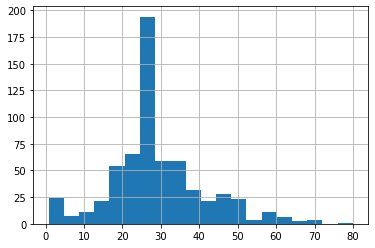

In [ ]:
dftrain.age.hist(bins=20)

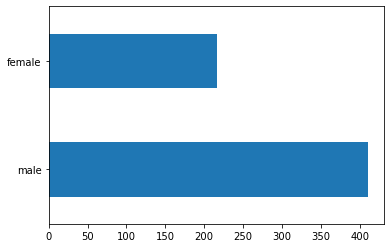

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

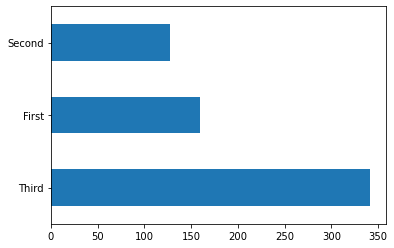

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

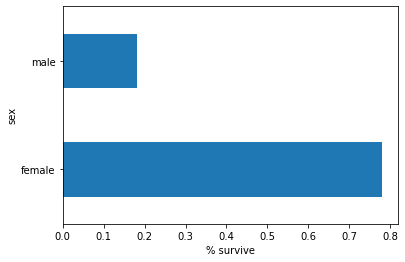

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [4]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [5]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [6]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

In [10]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.780303


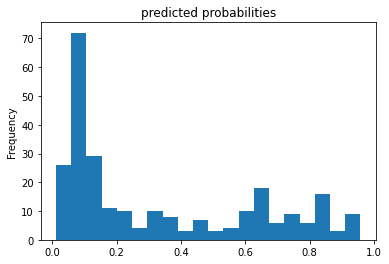

In [11]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [ ]:
###############clasificasion

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import pandas as pd

In [13]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [14]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

573/573 [==============================] - 0s 0us/step


In [15]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [16]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is now gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [17]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


In [18]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [19]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

In [23]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

In [24]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.933



In [29]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
SepalLength: 23
SepalLength: 12
SepalLength: 12
SepalLength: 3
SepalLength: 4
SepalLength: 2
SepalLength: 0.5
SepalWidth: 2
SepalWidth: 0.4
PetalLength: 0.5
PetalWidth: 0.3
Prediction is "Versicolor" (37.9%)


In [ ]:
###############modelo oculto de markov

In [31]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time
import tensorflow as tf

In [32]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.2, 0.8])  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[[0.5, 0.5],
                                                 [0.2, 0.8]])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

In [33]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [34]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:  
  print(mean.numpy())

[11.999999 11.1      10.830001 10.748999 10.724699 10.71741  10.715222]
